# 1. Adat tomorites

In [1]:
from tensorflow import keras

In [24]:
# MNIST mérete: 28x28

# enkóder: a Sequential API segítségével
# 16 db filter, 3x3 kernel size, relu activation
# 2-es pooling
# 32 db filter, 3x3 kernel size, relu activation
# 2-es pooling
# 64 db filter, 3x3 kernel size, relu activation
# 2-es pooling

encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2)
])

# itt (3 x 3 x 64) azaz 576-dimenziós lesz a reprezentáció, ellenőrizzük le!
# az mnist (28 x 28 x 1), tehát tömörítéshez nem jó
# viszont előtanításhoz igen, ha kevés a címkézett adatunk

encoder.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)         

In [25]:
# dekóder: ugyanaz, csak Conv2DTranspose rétegekkel
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid", activation="relu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same"),
    keras.layers.Reshape([28, 28])
])

decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 32)          18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 14, 14, 16)        4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 1)         145       
 Transpose)                                                      
                                                                 
 reshape_3 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 23233 (90.75 KB)
Trainable params: 23233 (90.75 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [26]:
# modell a teljes AE-re
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.summary()

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 3, 3, 64)          23296     
                                                                 
 sequential_4 (Sequential)   (None, 28, 28)            23233     
                                                                 
Total params: 46529 (181.75 KB)
Trainable params: 46529 (181.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
# tanítóadatok
from keras.datasets import mnist

(x_train, _) ,(x_test, _) = mnist.load_data()

print(x_train.shape, x_test.shape)

# teszt részt kettéválasztjuk még, hogy legyen külön validációs halmaz
from sklearn.model_selection import train_test_split
[x_test, x_valid] = train_test_split(x_test, test_size=0.5)

x_train = x_train / 255
x_valid = x_valid / 255
x_test = x_test / 255

print(x_train.shape, x_valid.shape, x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28) (5000, 28, 28) (5000, 28, 28)


In [6]:
# tanítás
autoencoder.fit(x_train, x_train,
                epochs = 10,
                batch_size = 128,
                shuffle = True,
                validation_data = (x_valid, x_valid))

Epoch 1/10
469/469 [==============================] - 18s 9ms/step - loss: 0.0370 - val_loss: 0.0194
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0172 - val_loss: 0.0154
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0146 - val_loss: 0.0136
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0132 - val_loss: 0.0125
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0123 - val_loss: 0.0118
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0100 - val_loss: 0.009

In [7]:
# néhány digiten encode és decode
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

157/157 [==============================] - 0s 2ms/step


In [8]:
# milyen méretű a háló közepe, a 'bottleneck'?
print(encoded_imgs.shape)

(5000, 3, 3, 16)


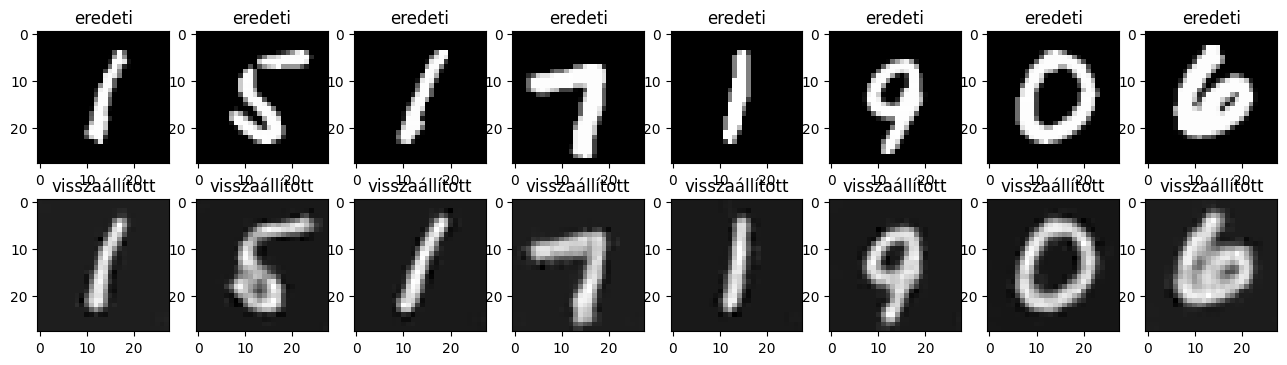

In [9]:
import matplotlib.pyplot as plt

# eredeti és visszaállított képek kirajzolása
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(2, n, i + 1)
  ax.set_title('eredeti')
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()

  # visszaállított
  ax = plt.subplot(2, n, i + 1 + n)
  ax.set_title('visszaállított')
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()

In [10]:
print(encoded_imgs[i].shape)

(3, 3, 16)


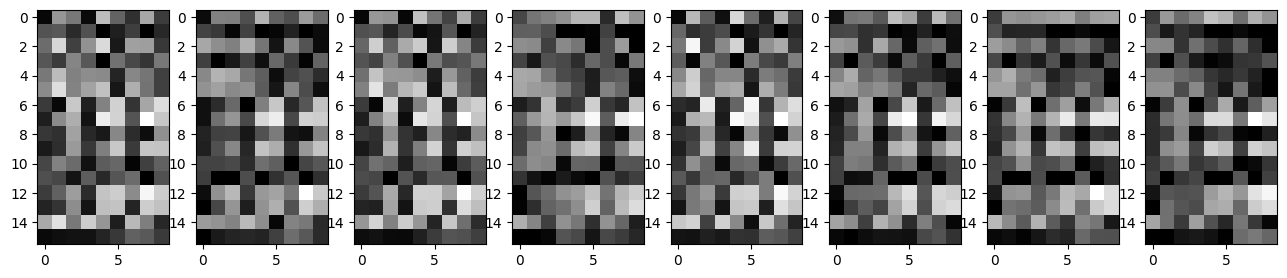

In [12]:
# encoder utáni eredmény, bottleneck reprezentáció
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(encoded_imgs[i].reshape(3*3, 64).T)
  plt.gray()

# 2. Zajszures

In [13]:
from tensorflow import keras

In [27]:
# ugyanaz az autoenkóder, mint az előző példában  (átmásolni ide, encoder+decoder)

autoencoder.summary()

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 3, 3, 64)          23296     
                                                                 
 sequential_4 (Sequential)   (None, 28, 28)            23233     
                                                                 
Total params: 46529 (181.75 KB)
Trainable params: 46529 (181.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# tanítóadatok, mint az előző példában
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _) ,(x_test, _) = mnist.load_data()

print(x_train.shape, x_test.shape)

# teszt részt kettéválasztjuk még, hogy legyen külön validációs halmaz
from sklearn.model_selection import train_test_split
[x_test, x_valid] = train_test_split(x_test, test_size=0.5)

x_train = x_train / 255
x_valid = x_valid / 255
x_test = x_test / 255

print(x_train.shape, x_valid.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28) (5000, 28, 28) (5000, 28, 28)


In [29]:
# fehérzaj hozzákeverése az adatokhoz
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(size=x_valid.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

In [30]:
# 0-1 közé
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_valid_noisy = np.clip(x_valid_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

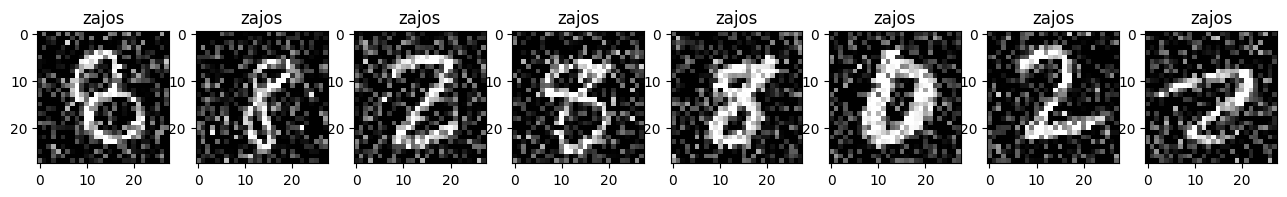

In [31]:
# zajos képek kirajzolása
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
  # eredeti
  ax = plt.subplot(1, n, i + 1)
  ax.set_title('zajos')
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()

In [32]:
# tanítás
# bemenet: zajos képek
# kimenet: eredeti (zajmentes) képek
autoencoder.fit(x_train_noisy, x_train,
               epochs = 10,
               batch_size = 128,
               shuffle = True,
               validation_data = (x_valid_noisy, x_valid))

Epoch 1/10
469/469 [==============================] - 6s 8ms/step - loss: 0.0310 - val_loss: 0.0161
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0142 - val_loss: 0.0127
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 4/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 6/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0080 - val_loss: 0.007

In [33]:
decoded_imgs = autoencoder.predict(x_test_noisy)

157/157 [==============================] - 1s 2ms/step


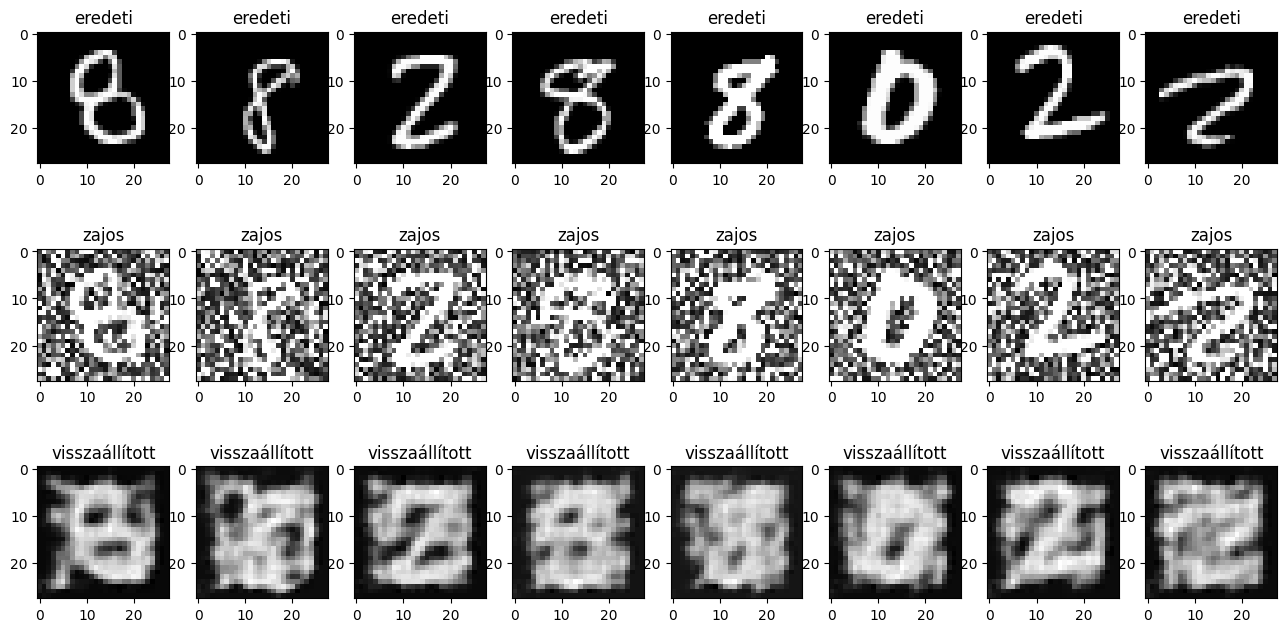

In [39]:
# eredeti, zajos és visszaállított képek kirajzolása
n = 8
plt.figure(figsize=(16, 8))
for i in range(n):
  # eredeti
  ax = plt.subplot(3, n, i + 1)
  ax.set_title('eredeti')
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()

  # zajos
  ax = plt.subplot(3, n, i + 1 + n)
  ax.set_title('zajos')
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()

  # visszaállított
  ax = plt.subplot(3, n, i + 1 + 2 * n)
  ax.set_title('visszaállított')
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
plt.show()

In [35]:
# konklúzió: zajmentesítésre használható az AE
# de: ez csak az adott zaj típusra működik jól...

157/157 [==============================] - 0s 3ms/step


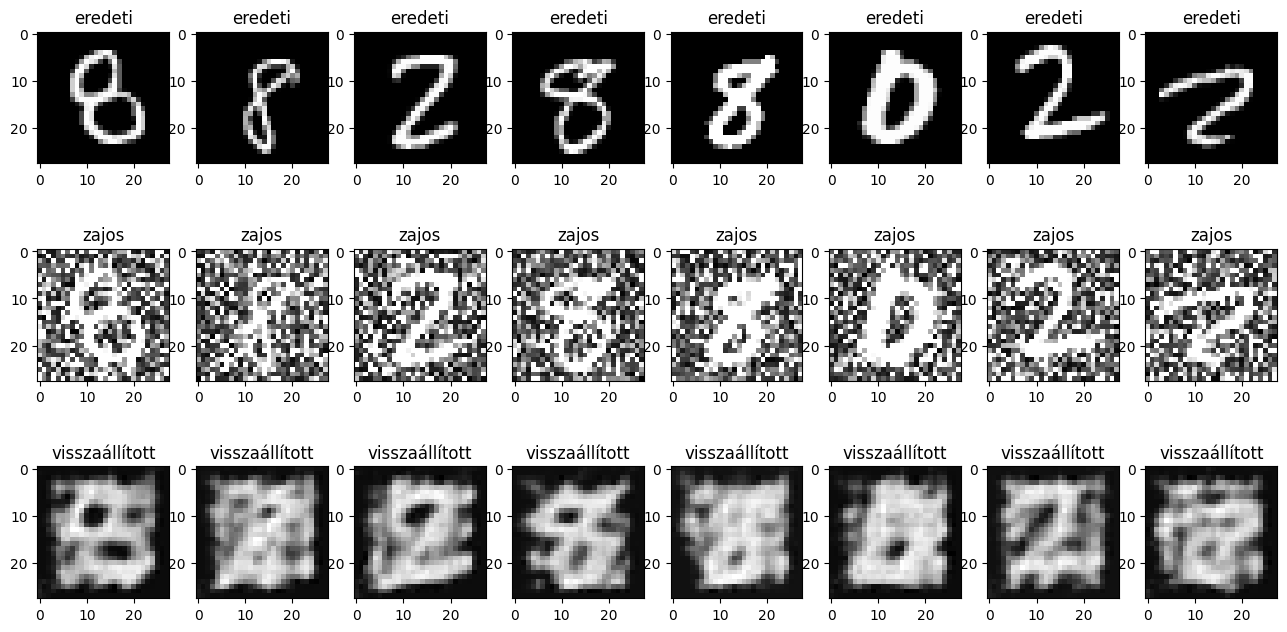

In [40]:
# más típusú zaj hozzáadása a képekhez
# szemre kb hasonlóan zajos; de mi lesz a denoising AE eredménye?
noise_factor = 0.4
x_test_noisy = x_test + noise_factor * np.random.lognormal(0, 1, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

# ez a rész ugyanaz, mint fent

decoded_imgs = autoencoder.predict(x_test_noisy)

# eredeti, zajos és visszaállított képek kirajzolása
n = 8
plt.figure(figsize=(16, 8))
for i in range(n):
  # eredeti
  ax = plt.subplot(3, n, i + 1)
  ax.set_title('eredeti')
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()

  # zajos
  ax = plt.subplot(3, n, i + 1 + n)
  ax.set_title('zajos')
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()

  # visszaállított
  ax = plt.subplot(3, n, i + 1 + 2 * n)
  ax.set_title('visszaállított')
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
plt.show()

# 3. Anomalia detektalas

In [41]:
# creditcard.csv: hitelkártya fizetési adatok kaggle versenyről

# időnként lassú a letöltés, akár 10p is lehet - időben elkezdeni!
# !wget smartlab.tmit.bme.hu/csapo/dl/creditcard.csv
!wget https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv

--2023-11-09 12:51:59--  https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102634230 (98M) [text/plain]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>]  97.88M   239MB/s    in 0.4s    

2023-11-09 12:51:59 (239 MB/s) - ‘creditcard.csv’ saved [102634230/102634230]



In [42]:
!ls -al

total 100252
drwxr-xr-x 1 root root      4096 Nov  9 12:51 .
drwxr-xr-x 1 root root      4096 Nov  9 12:33 ..
drwxr-xr-x 4 root root      4096 Nov  7 14:25 .config
-rw-r--r-- 1 root root 102634230 Nov  9 12:51 creditcard.csv
drwxr-xr-x 1 root root      4096 Nov  7 14:26 sample_data


In [43]:
!head creditcard.csv

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807134,-0.072781173,2.536346738,1.378155224,-0.33832077,0.462387778,0.239598554,0.098697901,0.36378697,0.090794172,-0.551599533,-0.617800856,-0.991389847,-0.311169354,1.468176972,-0.470400525,0.207971242,0.02579058,0.40399296,0.251412098,-0.018306778,0.277837576,-0.11047391,0.066928075,0.128539358,-0.189114844,0.133558377,-0.021053053,149.62,0
0,1.191857111,0.266150712,0.166480113,0.448154078,0.060017649,-0.082360809,-0.078802983,0.085101655,-0.255425128,-0.166974414,1.612726661,1.065235311,0.489095016,-0.143772296,0.635558093,0.463917041,-0.114804663,-0.18336127,-0.145783041,-0.069083135,-0.225775248,-0.638671953,0.101288021,-0.339846476,0.167170404,0.125894532,-0.008983099,0.014724169,2.69,0
1,-1.358354062,-1.340163075,1.773209343,0.379779593,-0.503198133,1.800499381,0.791460956,0.247675787,-1.514654323,0.207642865,0.624501459,0.066083685,0.717292731,-0.165

In [44]:
import tensorflow as tf
from tensorflow import keras

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [46]:
# adatok beolvasása pandas dataframe-be
df = pd.read_csv('creditcard.csv')

In [47]:
# először nézzük át, mi van az adatokban!

In [48]:
df.shape

(284807, 31)

In [49]:
# V1...V28: tömörített, anonimizált adat
# Time: időbélyeg
# Amount: összeg
# Class: osztály (0: normál, 1: csalás)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [50]:
# van-e benne hiányzó érték
df.isnull().values.any()

False

In [51]:
# normál / csalás tranzakciók aránya
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print('normál:', normal.shape, 'csalás:', frauds.shape)

normál: (284315, 31) csalás: (492, 31)


In [52]:
# mennyire különböző a normál / csalás tranzakciók összege?
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [53]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

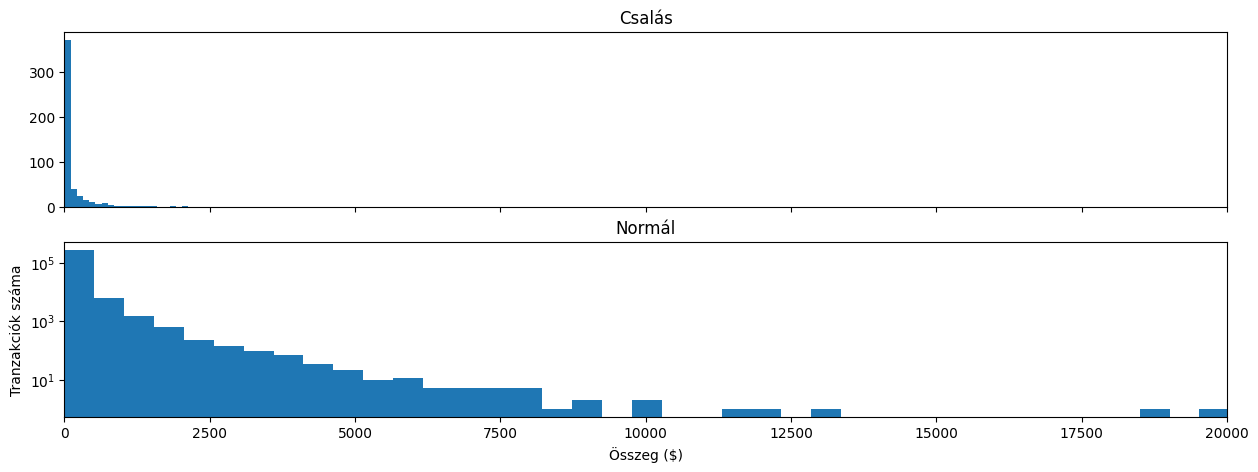

In [54]:
# mennyire különböző a normál / csalás tranzakciók összege?  - hisztogramon ábrázolva
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))

ax1.hist(frauds.Amount, bins = 20)
ax1.set_title('Csalás')

ax2.hist(normal.Amount, bins = 50)
ax2.set_title('Normál')
plt.xlabel('Összeg ($)')
plt.ylabel('Tranzakciók száma')
plt.xlim((0, 20000))
plt.yscale('log')

Text(0, 0.5, 'Összeg')

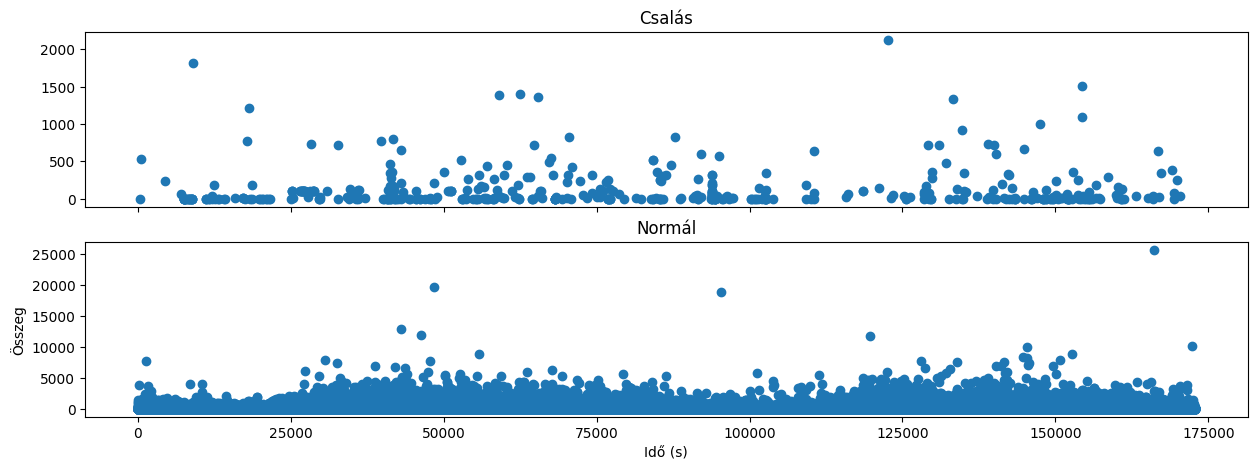

In [55]:
# csalás tranzakciók: látszik valamilyen mintázat időben?
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Csalás')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normál')

plt.xlabel('Idő (s)')
plt.ylabel('Összeg')


In [56]:
# adatok átrendezése: időtől nem függ, ezért azt az oszlopot töröljük
df = df.drop('Time',axis=1)

frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [57]:
# csak a normál adatokat vesszük ki, és erre tanítunk majd AE-t
X_normal = normal.drop('Class',axis=1).values

In [58]:
# train-valid-test split
X_normal_train, X_normal_test = train_test_split(X_normal,test_size=0.1)
X_normal_valid, X_normal_test = train_test_split(X_normal_test,test_size=0.5)

X_frauds_test = frauds.drop('Class',axis=1).values

In [59]:
# adatok normalizálása
data_scaler = MinMaxScaler()
X_normal_train = data_scaler.fit_transform(X_normal_train)

X_normal_valid = data_scaler.transform(X_normal_train)
X_normal_test = data_scaler.transform(X_normal_test)
X_frauds_test = data_scaler.transform(X_frauds_test)

In [60]:
X_normal_train.shape, X_normal_valid.shape, X_normal_test.shape, X_frauds_test.shape

((255883, 29), (255883, 29), (14216, 29), (492, 29))

In [61]:
# AE, bottleneck=2 ---> 2D-re tömörítjük az adatokat
data_in = keras.layers.Input(shape=(29,))
encoded = keras.layers.Dense(2,activation='tanh')(data_in)
decoded = keras.layers.Dense(29,activation='sigmoid')(encoded)
autoencoder = keras.models.Model(data_in,decoded)

In [62]:
autoencoder.compile(optimizer='adam',loss='mean_squared_error')

In [63]:
autoencoder.fit(X_normal_train, X_normal_train, epochs = 5, batch_size=128, validation_data=(X_normal_valid,X_normal_valid))

Epoch 1/5
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0060 - val_loss: 9.7921e-04
Epoch 2/5
2000/2000 [==============================] - 11s 6ms/step - loss: 0.0020 - val_loss: 7.4709e-04
Epoch 3/5
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0019 - val_loss: 7.1674e-04
Epoch 4/5
2000/2000 [==============================] - 9s 5ms/step - loss: 0.0019 - val_loss: 7.1509e-04
Epoch 5/5
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0019 - val_loss: 6.7814e-04


In [64]:
# nézzük meg, mit tanul meg az AE a normál tranzakciókról
reconstructions_normal = autoencoder.predict(X_normal_test)

445/445 [==============================] - 1s 2ms/step


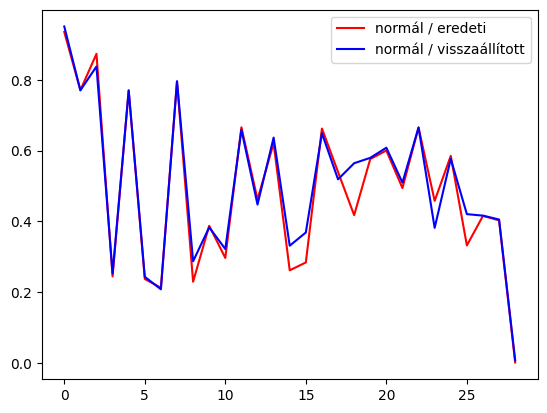

In [65]:
# kirajzolunk egy eredeti és visszaállított adatpontot
plt.plot(X_normal_test[10], 'r')
plt.plot(reconstructions_normal[10], 'b')
plt.legend(['normál / eredeti', 'normál / visszaállított'])

In [66]:
# nézzük meg, mit tanul meg az AE a csalás tranzakciókról
reconstructions_frauds = autoencoder.predict(X_frauds_test)

16/16 [==============================] - 0s 2ms/step


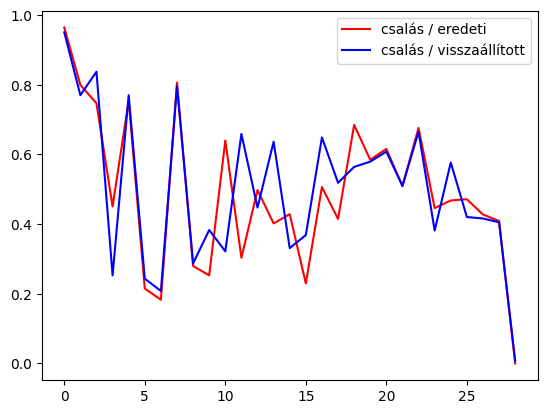

In [67]:
# kirajzolunk egy eredeti és visszaállított adatpontot
plt.plot(X_frauds_test[10], 'r')
plt.plot(reconstructions_frauds[10], 'b')
plt.legend(['csalás / eredeti', 'csalás / visszaállított'])

In [68]:
# megfigyelés: a 'csalás' tranzakciókat csak nagyobb hibával tudja visszaállítani az AE, mint a normál tranzakcióknál

445/445 [==============================] - 1s 2ms/step


Text(0, 0.5, 'Tranzakciók száma')

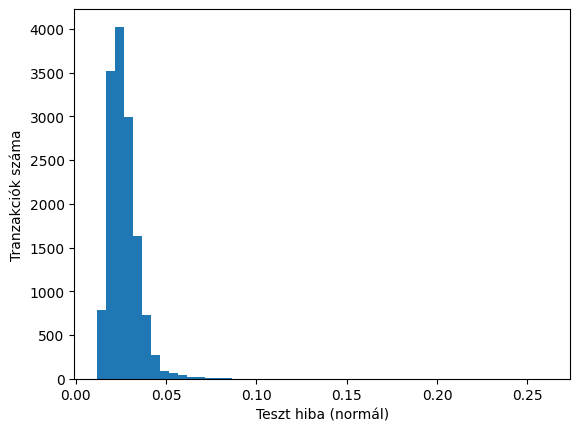

In [69]:
# nézzük meg a visszaállítás hibájának eloszlását a 'normál' tranzakciókon!

reconstructions_normal = autoencoder.predict(X_normal_test)
test_loss = tf.keras.losses.mae(reconstructions_normal, X_normal_test)

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Teszt hiba (normál)")
plt.ylabel("Tranzakciók száma")

In [70]:
# a fenti ábra alapján úgy tűnik, hogy ha a 'teszt hiba' > 0.05, akkor gyanús az adat
# azaz ezt érdemes a normál / csalás közti küszöb-nek beállítani!

16/16 [==============================] - 0s 2ms/step


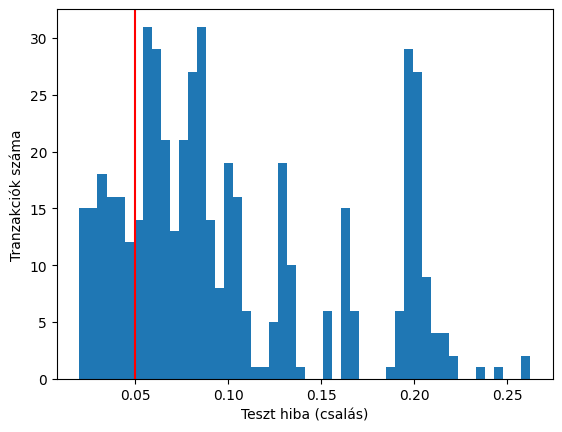

In [71]:
# nézzük meg a visszaállítás hibájának eloszlását a 'csalás' tranzakciókon!

reconstructions_frauds = autoencoder.predict(X_frauds_test)
test_loss = tf.keras.losses.mae(reconstructions_frauds, X_frauds_test)

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Teszt hiba (csalás)")
plt.ylabel("Tranzakciók száma")

# és tegyük rá az ábrára a fent megállapított a 0.05-ös küszöböt
threshold = 0.05
plt.axvline(threshold, color='r')


In [72]:
# konklúzió: nagyon egyszerű AE hálózattal sikerült a csalás tranzakciók egy részét felderítenünk!